In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CIFAR10

cifar = CIFAR10(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))]))

Files already downloaded and verified


In [2]:
img, label = cifar[0]
print('Label: ', label)
print(img[:,10:15,10:15])
print()
torch.min(img), torch.max(img)

Label:  6
tensor([[[-0.3725, -0.2392, -0.2941, -0.2314,  0.0745],
         [-0.1294,  0.1451,  0.0667,  0.2784,  0.3255],
         [ 0.0824,  0.6706,  0.3961,  0.4980,  0.6549],
         [ 0.2941,  0.7961,  0.4353,  0.4980,  0.8745],
         [ 0.5059,  0.4510,  0.1373,  0.5922,  0.7490]],

        [[-0.6863, -0.5843, -0.6471, -0.5608, -0.2863],
         [-0.5294, -0.3255, -0.3882, -0.0902, -0.0980],
         [-0.3804,  0.1765, -0.0353,  0.1765,  0.3255],
         [-0.1686,  0.3804,  0.0745,  0.2392,  0.6941],
         [ 0.1922,  0.1608, -0.2078,  0.2706,  0.5686]],

        [[-0.8980, -0.8667, -0.8667, -0.7647, -0.5529],
         [-0.8902, -0.8275, -0.8196, -0.3961, -0.4588],
         [-0.8510, -0.5373, -0.6784, -0.2314, -0.0431],
         [-0.6078, -0.2784, -0.5529, -0.1922,  0.3804],
         [-0.1137, -0.1608, -0.6000, -0.0510,  0.3333]]])



(tensor(-1.), tensor(1.))

In [3]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 6


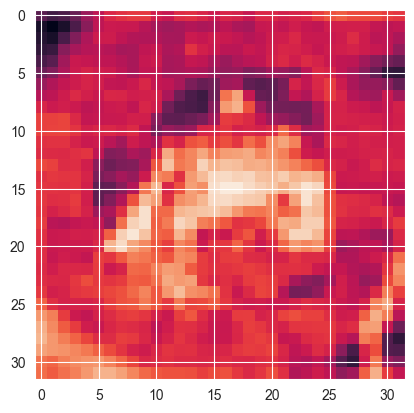

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0])
print('Label:', label)

In [5]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(cifar, batch_size, shuffle=True)

first batch
torch.Size([100, 3, 32, 32])
tensor([5, 3, 6, 4, 1, 7, 7, 9, 4, 8, 1, 6, 2, 8, 4, 5, 0, 9, 9, 4, 5, 8, 5, 3,
        3, 5, 6, 7, 0, 1, 7, 5, 9, 7, 3, 1, 7, 0, 9, 2, 6, 2, 4, 8, 0, 9, 0, 9,
        7, 5, 6, 2, 4, 3, 0, 3, 9, 3, 6, 5, 8, 1, 5, 3, 0, 4, 2, 0, 9, 9, 5, 7,
        3, 9, 3, 0, 3, 1, 5, 5, 1, 6, 2, 9, 0, 8, 1, 4, 7, 5, 2, 8, 7, 2, 9, 1,
        1, 9, 5, 1])


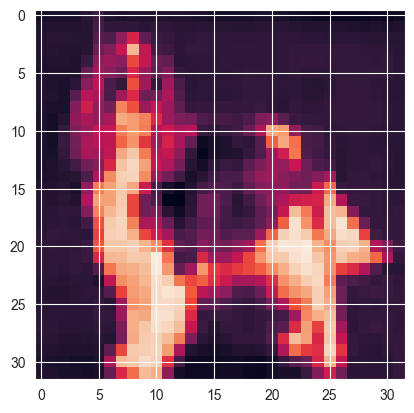

In [6]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0])
    print(label_batch)
    break

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
image_size = 3072 # This is important to understand We are setting the Image_ size to 3072 because Our Images size is 32 * 32 and it has 3 channels.
hidden_size = 256

In [9]:
import torch.nn as nn

Discriminator = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [10]:
print(Discriminator)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)


In [13]:
Discriminator.to(device);

In [14]:
latent_size = 64

In [15]:
Generator = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [16]:
print(Generator)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=3072, bias=True)
  (5): Tanh()
)


In [17]:
y = Generator(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 32,32)).detach())

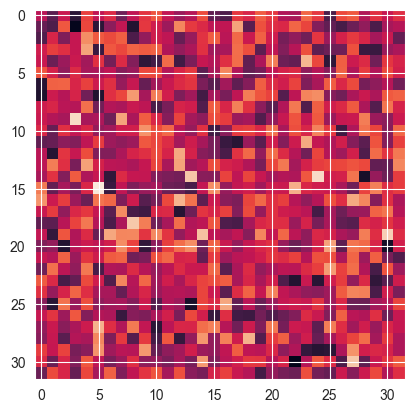

In [18]:
plt.imshow(gen_imgs[0]);

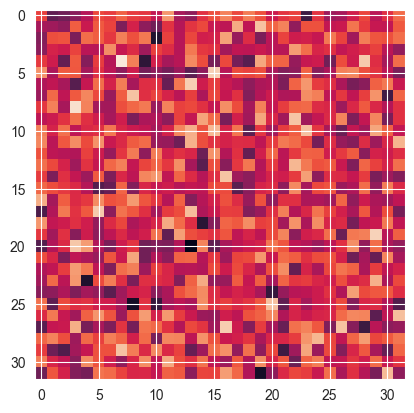

In [19]:
plt.imshow(gen_imgs[1]);

In [20]:
Generator.to(device);

In [21]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(Discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(Generator.parameters(), lr=0.0002)

In [22]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = Discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator(z)
    outputs = Discriminator(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [23]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(Discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [24]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

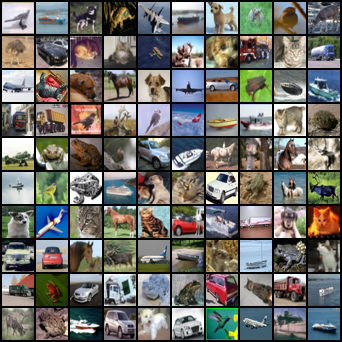

In [25]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 3, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


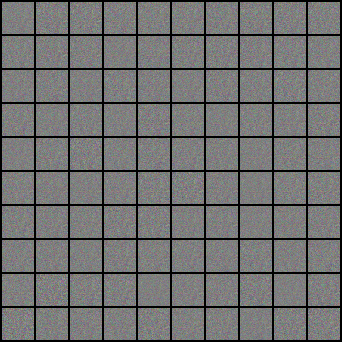

In [26]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = Generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [29]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size,-1).to(device)


        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    if epoch % 10 == 0:
        save_fake_images(epoch+1)

Epoch [0/100], Step [200/500], d_loss: 0.2609, g_loss: 3.9310, D(x): 0.91, D(G(z)): 0.08
Epoch [0/100], Step [400/500], d_loss: 0.2358, g_loss: 4.8064, D(x): 0.91, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/100], Step [200/500], d_loss: 0.3887, g_loss: 3.4586, D(x): 0.89, D(G(z)): 0.11
Epoch [1/100], Step [400/500], d_loss: 0.2058, g_loss: 4.1695, D(x): 0.93, D(G(z)): 0.08
Epoch [2/100], Step [200/500], d_loss: 0.3163, g_loss: 3.3963, D(x): 0.94, D(G(z)): 0.15
Epoch [2/100], Step [400/500], d_loss: 0.7908, g_loss: 4.2280, D(x): 0.85, D(G(z)): 0.15
Epoch [3/100], Step [200/500], d_loss: 0.3138, g_loss: 4.0590, D(x): 0.91, D(G(z)): 0.10
Epoch [3/100], Step [400/500], d_loss: 0.3225, g_loss: 3.6702, D(x): 0.93, D(G(z)): 0.13
Epoch [4/100], Step [200/500], d_loss: 0.3997, g_loss: 3.9191, D(x): 0.88, D(G(z)): 0.12
Epoch [4/100], Step [400/500], d_loss: 0.4442, g_loss: 4.0860, D(x): 0.92, D(G(z)): 0.18
Epoch [5/100], Step [200/500], d_loss: 0.3267, g_loss: 4.0849, D(x): 0.91, D(G(z))

In [30]:
torch.save(Generator.state_dict(), 'G.ckpt')
torch.save(Discriminator.state_dict(), 'D.ckpt')

In [50]:
z = torch.randn(batch_size, latent_size).to(device)
# generator = Generator(z)
synthetic_data = list()
with torch.no_grad():
    for _ in range(100):
        noise = torch.randn(1, latent_size).to(device)
        generated_image = Generator(noise).view(3, 32, 32)
        synthetic_data.append(generated_image)

TypeError: Invalid shape (3, 32, 32) for image data

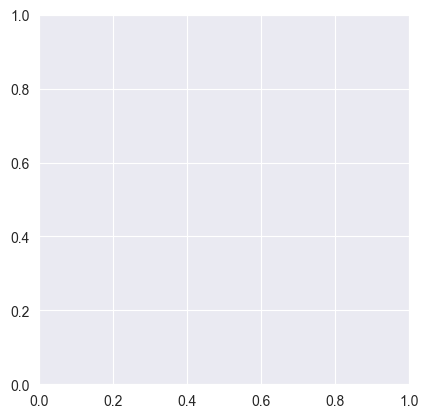

In [52]:
plt.imshow(synthetic_data[1].detach().cpu().numpy());